In [1]:
#PACKAGE IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras import optimizers
import os
from keras.preprocessing.image import ImageDataGenerator
from random import sample,seed
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Import Dataframe
path='Small Img'
df=pd.read_csv('2012_2019_PlatteRiverWeir_features_merged_all.csv')
df=df.iloc[:,2:7].drop(columns=[' Agency',' SiteNumber',' TimeZone'])
df.rename(columns={' Filename':'Filename', ' Stage':'Stage'},inplace=True)
df['Filename'] = df['Filename'].apply(lambda x: f"{path}/{x}")
df

,Filename,Stage
0,Small Img/StateLineWeir_20120609_Farrell_001.jpg,2.99
1,Small Img/StateLineWeir_20120609_Farrell_002.jpg,2.99
2,Small Img/StateLineWeir_20120609_Farrell_003.jpg,2.96
3,Small Img/StateLineWeir_20120609_Farrell_004.jpg,2.94
4,Small Img/StateLineWeir_20120609_Farrell_005.jpg,2.94
...,...,...
42054,Small Img/StateLineWeir_20191011_Farrell_409.jpg,2.54
42055,Small Img/StateLineWeir_20191011_Farrell_410.jpg,2.54
42056,Small Img/StateLineWeir_20191011_Farrell_411.jpg,2.54
42057,Small Img/StateLineWeir_20191011_Farrell_412.jpg,2.54


In [4]:
df_class=pd.read_csv('class_df.csv')
df_class['filename'] = df_class['filename'].apply(lambda x: f"{path}/{x.split('/')[5]}")
df_class

,filename,usable
0,Small Img/StateLineWeir_20170122_Farrell_908.jpg,0
1,Small Img/StateLineWeir_20170112_Farrell_637.jpg,0
2,Small Img/StateLineWeir_20161227_Farrell_178.jpg,1
3,Small Img/StateLineWeir_20161231_Farrell_279.jpg,0
4,Small Img/StateLineWeir_20170117_Farrell_750.jpg,0
...,...,...
55798,Small Img/StateLineWeir_20160313_Farrell_747.JPG,0
55799,Small Img/StateLineWeir_20160104_Farrell_310.JPG,1
55800,Small Img/StateLineWeir_20160104_Farrell_306.JPG,1
55801,Small Img/StateLineWeir_20160220_Farrell_599.JPG,1


In [5]:
zeroes_subset = df_class.loc[df_class["usable"] == 0, :]
number_of_0s = len(zeroes_subset)

print(number_of_0s)
ones_subset = df_class.loc[df_class["usable"] == 1, :]
sampled_ones = ones_subset.sample(number_of_0s, random_state=42)

print(sampled_ones)

clean_df = pd.concat([zeroes_subset, sampled_ones], ignore_index=True)

print(clean_df)

13744
                                               filename  usable
33372  Small Img/StateLineWeir_20180513_Farrell_417.jpg       1
2115   Small Img/StateLineWeir_20180703_Farrell_929.jpg       1
10395  Small Img/StateLineWeir_20140827_Farrell_638.JPG       1
28301  Small Img/StateLineWeir_20190119_Farrell_899.jpg       1
50754  Small Img/StateLineWeir_20140710_Farrell_546.JPG       1
...                                                 ...     ...
9500   Small Img/StateLineWeir_20160610_Farrell_736.JPG       1
38929  Small Img/StateLineWeir_20180819_Farrell_357.jpg       1
26132  Small Img/StateLineWeir_20130514_Farrell_072.JPG       1
47998  Small Img/StateLineWeir_20150930_Farrell_619.JPG       1
33891  Small Img/StateLineWeir_20180502_Farrell_079.jpg       1

[13744 rows x 2 columns]
                                               filename  usable
0      Small Img/StateLineWeir_20170122_Farrell_908.jpg       0
1      Small Img/StateLineWeir_20170112_Farrell_637.jpg       0
2      S

In [6]:
df_class=clean_df
df_class['usable']=df_class['usable'].astype(str)
df_class

,filename,usable
0,Small Img/StateLineWeir_20170122_Farrell_908.jpg,0
1,Small Img/StateLineWeir_20170112_Farrell_637.jpg,0
2,Small Img/StateLineWeir_20161231_Farrell_279.jpg,0
3,Small Img/StateLineWeir_20170117_Farrell_750.jpg,0
4,Small Img/StateLineWeir_20170109_Farrell_552.jpg,0
...,...,...
27483,Small Img/StateLineWeir_20160610_Farrell_736.JPG,1
27484,Small Img/StateLineWeir_20180819_Farrell_357.jpg,1
27485,Small Img/StateLineWeir_20130514_Farrell_072.JPG,1
27486,Small Img/StateLineWeir_20150930_Farrell_619.JPG,1


In [7]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=64
epochs=10

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df,
    x_col='Filename',
    y_col='Stage',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False
)

Found 42059 validated image filenames.


In [9]:
c_test_datagen = ImageDataGenerator(rescale=1./255)

c_test_generator = c_test_datagen.flow_from_dataframe(
    df_class,
    x_col='filename',
    y_col='usable',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

Found 27473 validated image filenames belonging to 2 classes.


c:\Users\wawer\anaconda3\envs\tf_2.11\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 15 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [10]:
Classifier=keras.models.load_model('Classifier')
CNN=keras.models.load_model('CNN', custom_objects = {"r2_score": r2_score})
VGG=keras.models.load_model('VGG', custom_objects = {"r2_score": r2_score})

In [11]:
def predict_value(path,model):   
	img=tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
	#img = keras.preprocessing.image.load_img(image)
	#img = tf.image.resize(img,[150, 150])
	#img = keras.utils.img_to_array(img)
	img = np.expand_dims(img, axis = 0)
	res=model.predict(img/255)
	
	return res

In [12]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [13]:
import os

img_list=os.listdir(path)

print(len(img_list))

out = display(progress(0, len(img_list)), display_id=True)

Classres=[]
CNNres=[]
VGGres=[]
truestage=[]
trueclass=[]
i=0

for img in img_list:
    time.sleep(0.02)
    out.update(progress(i, len(img_list)))

    img_path = f'{path}/{img}'

    '''if img_path in df['Filename'].unique():
        CNNres.append(predict_value(img_path,CNN))
        VGGres.append(predict_value(img_path,VGG))
        truestage.append(df.loc[df['Filename'].isin([img_path])]['Stage'].values[0])'''

    if img_path in df_class['filename'].unique():
        Classres.append(predict_value(img_path,Classifier).round())
        trueclass.append(df_class.loc[df_class['filename'].isin([img_path])]['usable'].values[0])
    
    i+=1


55788


1/1 [==============================] - 0s 11ms/step


In [16]:
Classres=[str(int(x[0][0]))for x in Classres]
Classres

['1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0'

In [17]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(trueclass, Classres)
cm

array([[13615,   114],
       [  272, 13472]], dtype=int64)

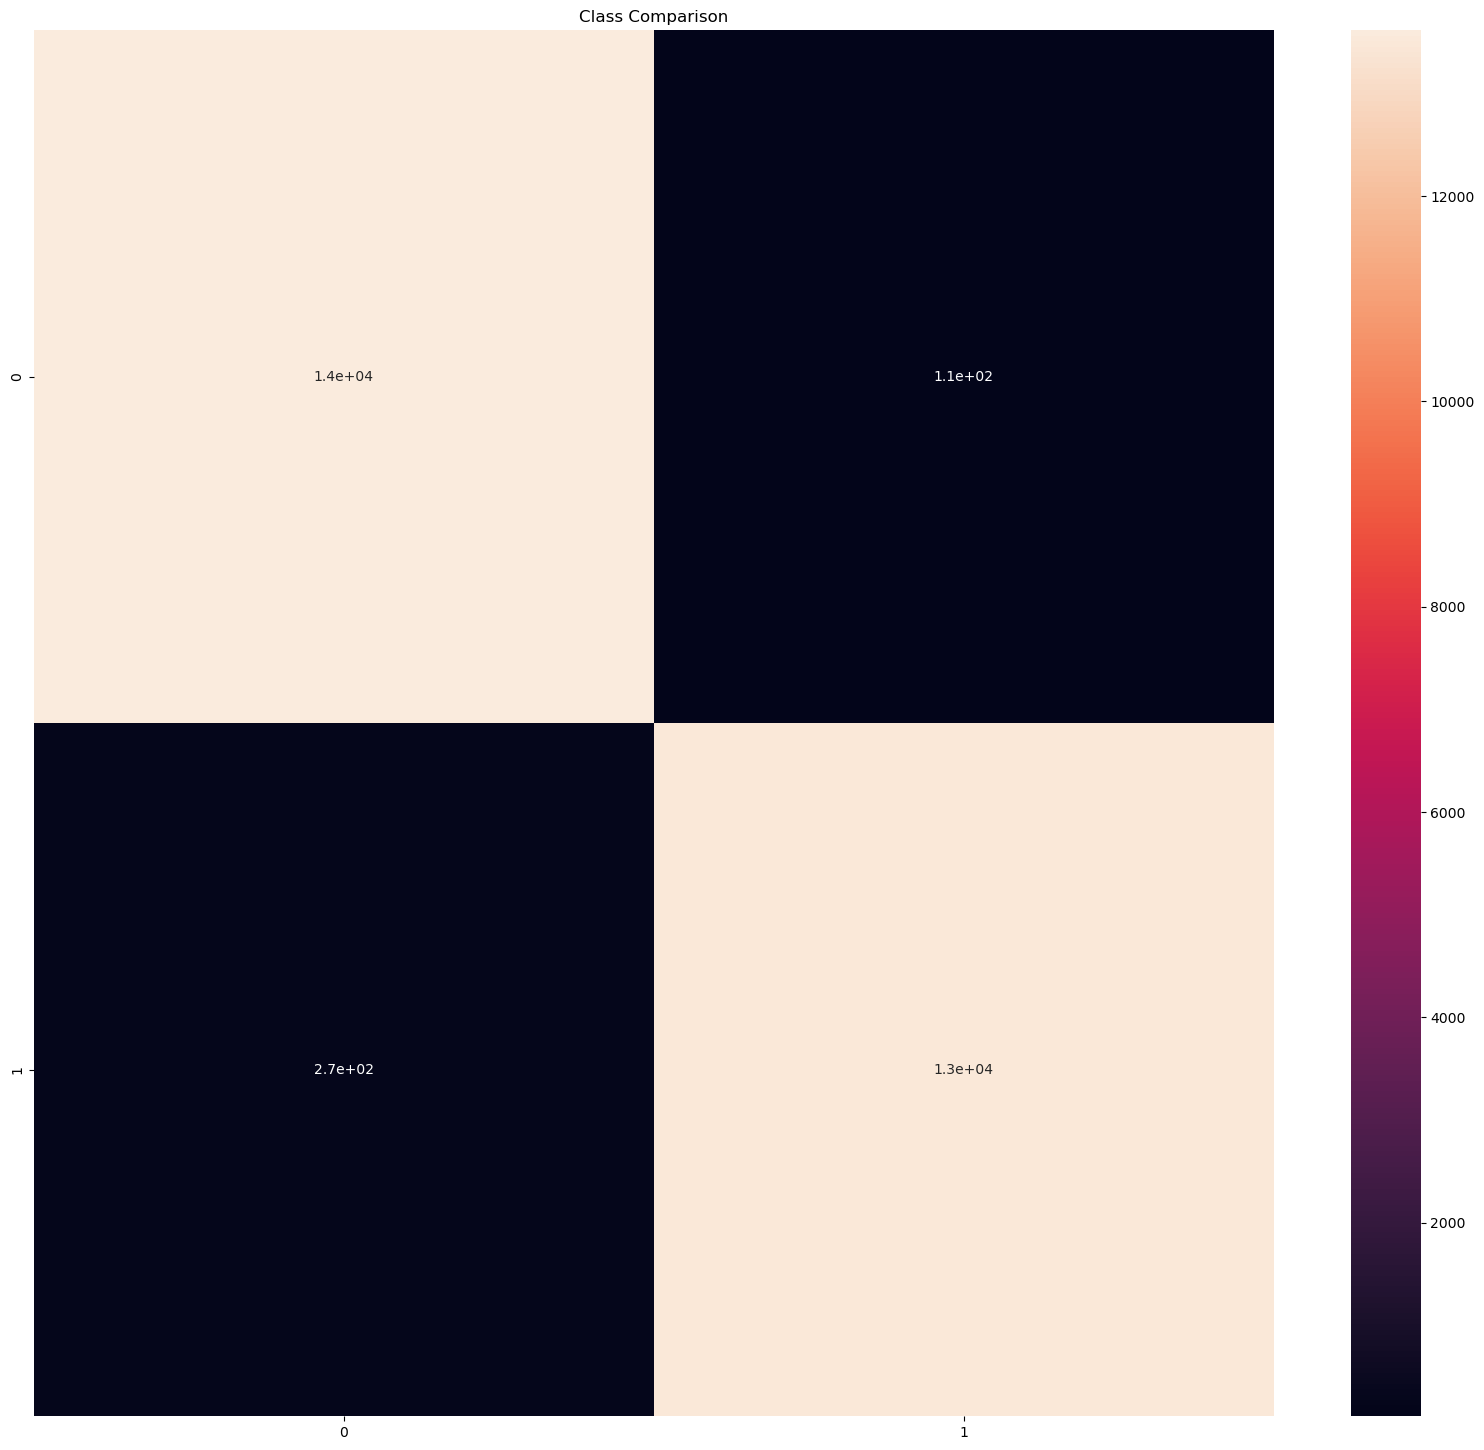

In [18]:
fig, ax = plt.subplots(figsize=(20, 18))
plt.title('Class Comparison')
ax=sns.heatmap(cm, annot=True)

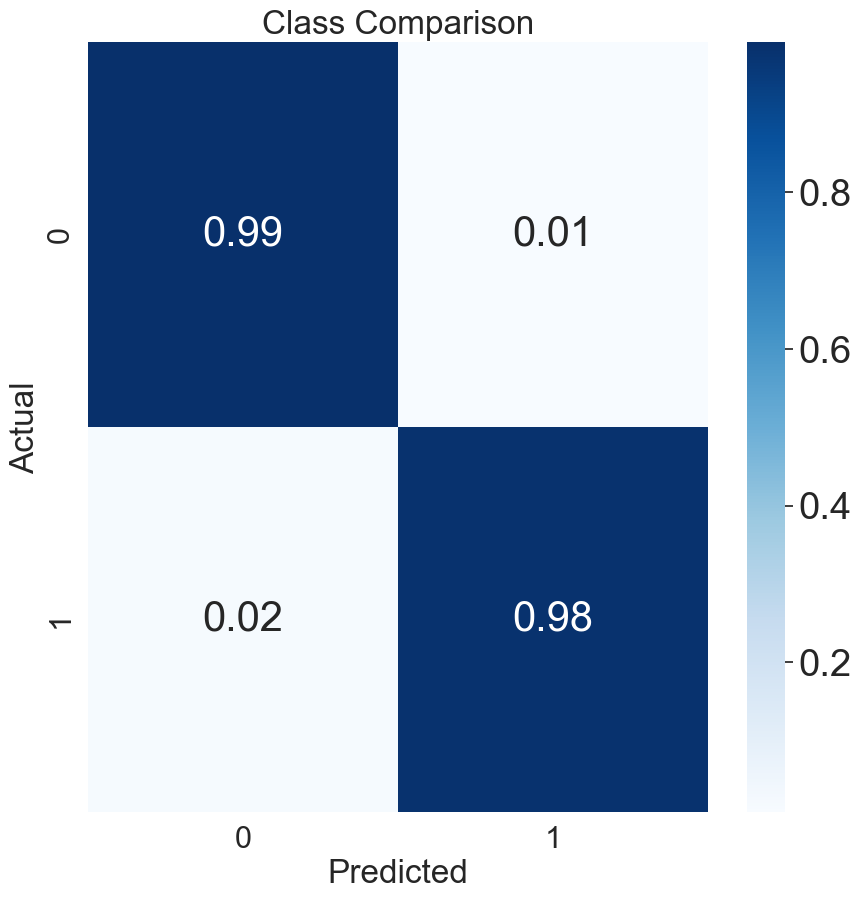

In [23]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Class Comparison')
sns.set(font_scale=2.5)
sns.heatmap(cmn, annot=True, fmt='.2f', cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [24]:
org=pd.read_csv('2012_2019_PlatteRiverWeir_features_merged_all.csv')
org

,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,StateLineWeir_20191011_Farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:53,4288,...,2446,1900,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,StateLineWeir_20191011_Farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:54,4288,...,2440,1900,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,StateLineWeir_20191011_Farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:55,4288,...,2447,1900,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,StateLineWeir_20191011_Farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:56,4288,...,2443,1900,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896


In [25]:
df['Time']=org[' CaptureTime']
df['Time']=pd.to_datetime(df['Time'])
df

,Filename,Stage,Time
0,Small Img/StateLineWeir_20120609_Farrell_001.jpg,2.99,2012-06-09 13:09:07
1,Small Img/StateLineWeir_20120609_Farrell_002.jpg,2.99,2012-06-09 13:10:29
2,Small Img/StateLineWeir_20120609_Farrell_003.jpg,2.96,2012-06-09 13:44:01
3,Small Img/StateLineWeir_20120609_Farrell_004.jpg,2.94,2012-06-09 14:44:30
4,Small Img/StateLineWeir_20120609_Farrell_005.jpg,2.94,2012-06-09 15:44:59
...,...,...,...
42054,Small Img/StateLineWeir_20191011_Farrell_409.jpg,2.54,2019-10-11 08:59:53
42055,Small Img/StateLineWeir_20191011_Farrell_410.jpg,2.54,2019-10-11 09:59:52
42056,Small Img/StateLineWeir_20191011_Farrell_411.jpg,2.54,2019-10-11 10:59:52
42057,Small Img/StateLineWeir_20191011_Farrell_412.jpg,2.54,2019-10-11 11:59:53


In [26]:
#Classres=Classifier.predict(c_test_generator)
CNNres=CNN.predict(test_generator)
VGGres=VGG.predict(test_generator)

658/658 [==============================] - 218s 322ms/step


In [27]:
df['StageCNN']=CNNres
df['StageVGG']=VGGres
df

,Filename,Stage,Time,StageCNN,StageVGG
0,Small Img/StateLineWeir_20120609_Farrell_001.jpg,2.99,2012-06-09 13:09:07,3.082905,3.103791
1,Small Img/StateLineWeir_20120609_Farrell_002.jpg,2.99,2012-06-09 13:10:29,3.110087,3.080180
2,Small Img/StateLineWeir_20120609_Farrell_003.jpg,2.96,2012-06-09 13:44:01,3.110235,3.099741
3,Small Img/StateLineWeir_20120609_Farrell_004.jpg,2.94,2012-06-09 14:44:30,3.004991,3.115599
4,Small Img/StateLineWeir_20120609_Farrell_005.jpg,2.94,2012-06-09 15:44:59,3.053760,3.168574
...,...,...,...,...,...
42054,Small Img/StateLineWeir_20191011_Farrell_409.jpg,2.54,2019-10-11 08:59:53,2.502902,2.572635
42055,Small Img/StateLineWeir_20191011_Farrell_410.jpg,2.54,2019-10-11 09:59:52,2.542003,2.562398
42056,Small Img/StateLineWeir_20191011_Farrell_411.jpg,2.54,2019-10-11 10:59:52,2.492129,2.513643
42057,Small Img/StateLineWeir_20191011_Farrell_412.jpg,2.54,2019-10-11 11:59:53,2.591140,2.518885


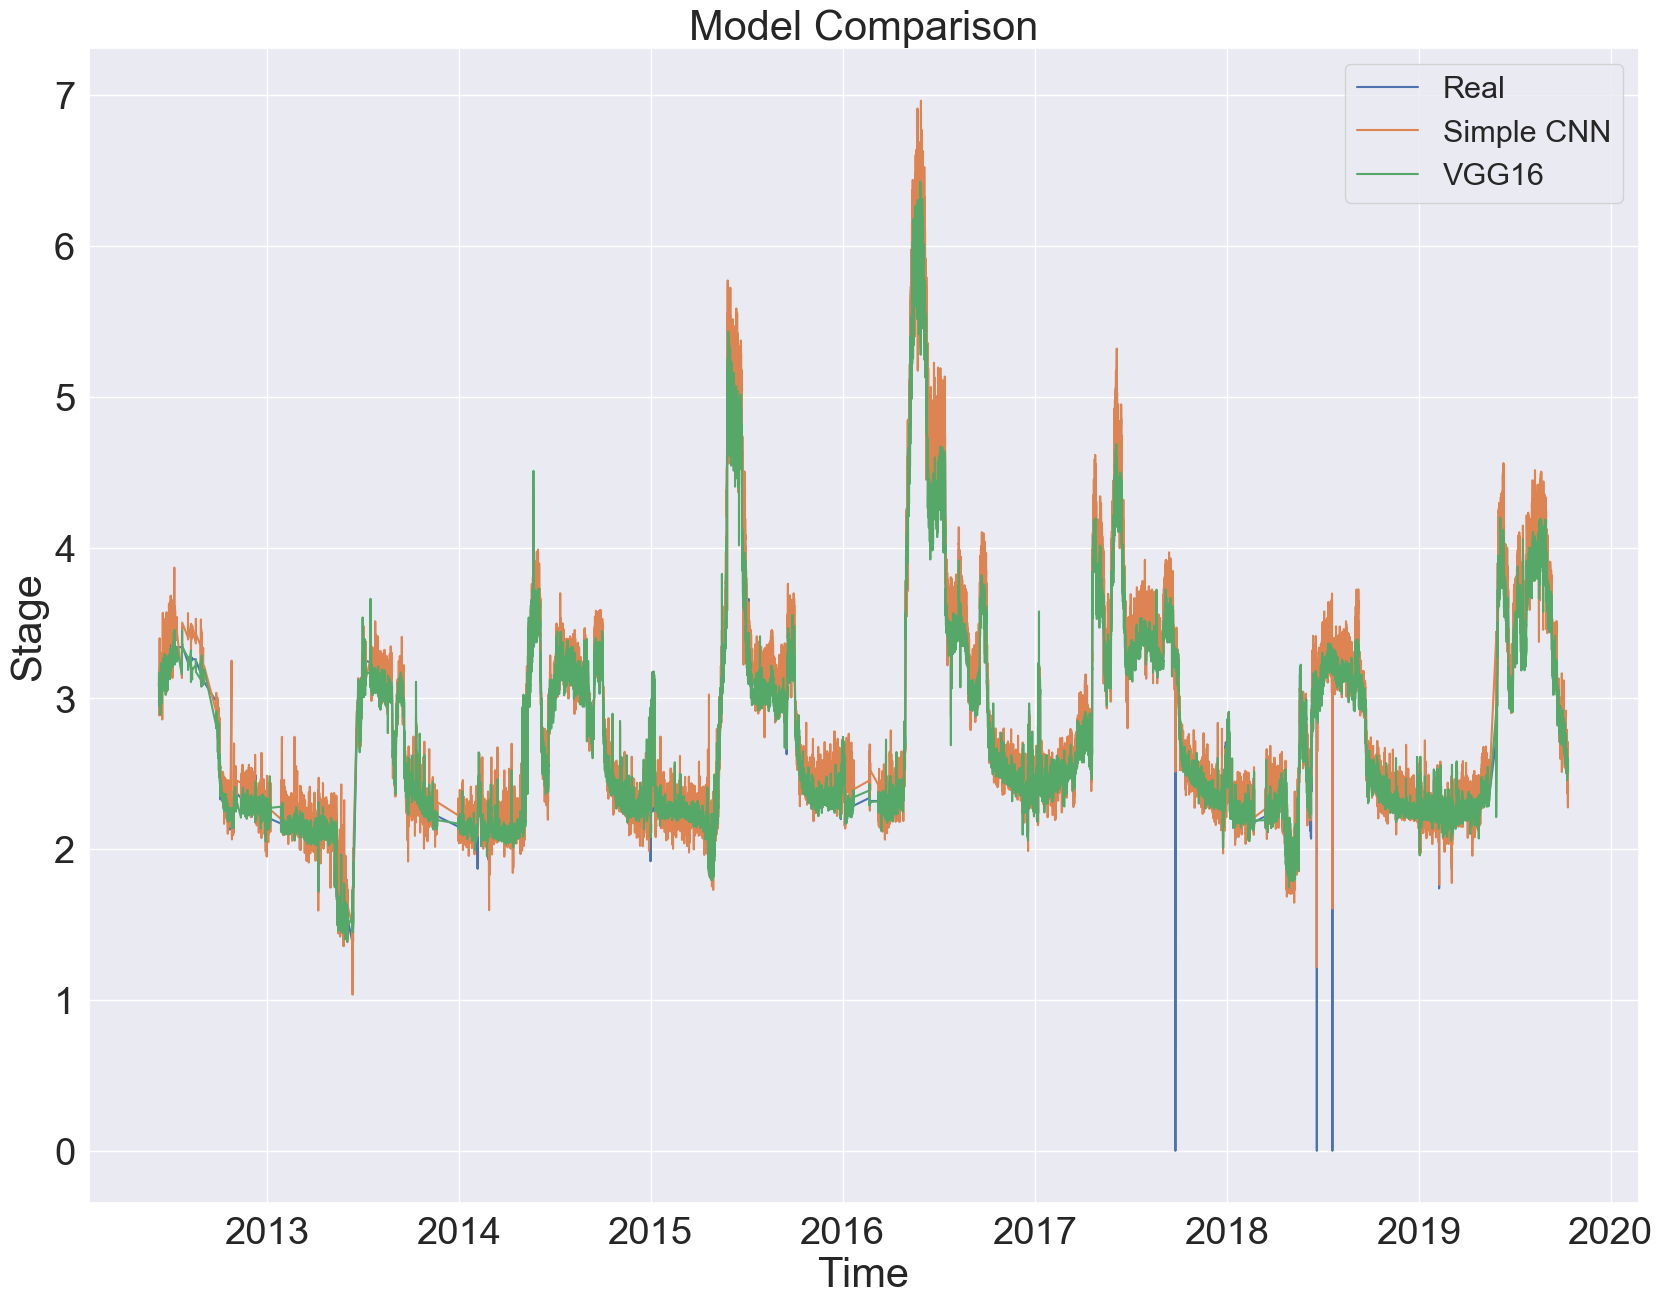

In [28]:
fig, ax = plt.subplots(figsize=(20, 15))
plt.title('Model Comparison')
sns.set(font_scale=2) 
ax=sns.lineplot(data=df, x="Time", y="Stage",label='Real')
ax=sns.lineplot(data=df, x="Time", y="StageCNN",label='Simple CNN')
ax=sns.lineplot(data=df, x="Time", y="StageVGG", label='VGG16')